In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Thu Jan 11 22:07:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    17W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-13/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


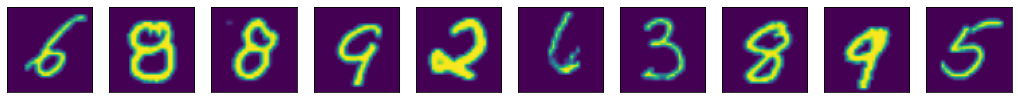

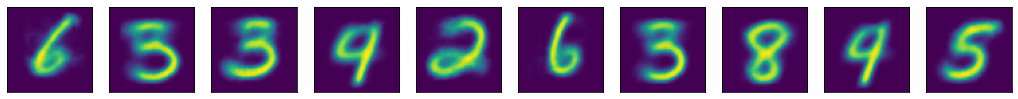

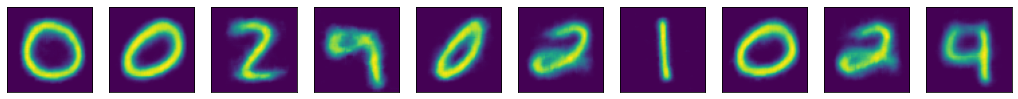

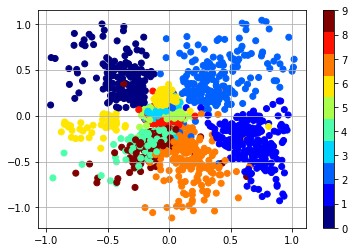

27001
lse_loss 0.00014698304585181177
recon_loss 0.1175173744559288
27002
lse_loss 9.901216253638268e-05
recon_loss 0.11571463197469711
27003
lse_loss 0.00011260523024247959
recon_loss 0.10189425945281982
27004
lse_loss 0.00010682333959266543
recon_loss 0.10840031504631042
27005
lse_loss 0.00010744426981545985
recon_loss 0.11650438606739044
27006
lse_loss 9.443497401662171e-05
recon_loss 0.12406059354543686
27007
lse_loss 0.00016821383906062692
recon_loss 0.11253973096609116
27008
lse_loss 0.00013517672778107226
recon_loss 0.12186434119939804
27009
lse_loss 0.0001063652234734036
recon_loss 0.12358206510543823
27010
lse_loss 8.52461889735423e-05
recon_loss 0.1318812370300293
27011
lse_loss 0.00015966528735589236
recon_loss 0.11742034554481506
27012
lse_loss 0.00017058647063095123
recon_loss 0.10775074362754822
27013
lse_loss 0.00011532798816915601
recon_loss 0.1249522864818573
27014
lse_loss 0.00014007517893332988
recon_loss 0.10072484612464905
27015
lse_loss 0.0001350143866147846
recon

27125
lse_loss 0.0010167452273890376
recon_loss 0.11027040332555771
27126
lse_loss 0.00010940409265458584
recon_loss 0.11549188941717148
27127
lse_loss 0.00024268620472867042
recon_loss 0.0999220460653305
27128
lse_loss 0.0001425784721504897
recon_loss 0.10438631474971771
27129
lse_loss 0.00015548986266367137
recon_loss 0.10813196003437042
27130
lse_loss 0.00012931569654028863
recon_loss 0.11052565276622772
27131
lse_loss 0.0001349193335045129
recon_loss 0.10587787628173828
27132
lse_loss 0.00010733403178164735
recon_loss 0.10078106820583344
27133
lse_loss 9.339985263068229e-05
recon_loss 0.11742241680622101
27134
lse_loss 0.00014139914128463715
recon_loss 0.10534647107124329
27135
lse_loss 0.00014053894847165793
recon_loss 0.10816444456577301
27136
lse_loss 0.00011345610255375504
recon_loss 0.10333019495010376
27137
lse_loss 0.00011941038246732205
recon_loss 0.11458203196525574
27138
lse_loss 0.00011500708933454007
recon_loss 0.1113189309835434
27139
lse_loss 0.0001425035879947245
rec

27250
lse_loss 0.00011621358862612396
recon_loss 0.09598582983016968
27251
lse_loss 0.00014138082042336464
recon_loss 0.10624732822179794
27252
lse_loss 0.00014817205374129117
recon_loss 0.10393458604812622
27253
lse_loss 0.00017043971456587315
recon_loss 0.09521828591823578
27254
lse_loss 0.00034422666067257524
recon_loss 0.130937859416008
27255
lse_loss 0.00012989755487069488
recon_loss 0.1176411509513855
27256
lse_loss 0.00011527468450367451
recon_loss 0.09515941143035889
27257
lse_loss 0.00012582507042679936
recon_loss 0.11530103534460068
27258
lse_loss 0.00012201201025163755
recon_loss 0.10950158536434174
27259
lse_loss 0.00011065147555200383
recon_loss 0.11097049713134766
27260
lse_loss 0.0002564685419201851
recon_loss 0.10114123672246933
27261
lse_loss 0.00013827250222675502
recon_loss 0.09669499099254608
27262
lse_loss 0.00011248007649555802
recon_loss 0.10848651826381683
27263
lse_loss 9.396875248057768e-05
recon_loss 0.10612498968839645
27264
lse_loss 0.00013296998804435134
r

27376
lse_loss 0.00015891777002252638
recon_loss 0.1099623367190361
27377
lse_loss 0.00015040015568956733
recon_loss 0.11571909487247467
27378
lse_loss 0.001978611806407571
recon_loss 0.09352636337280273
27379
lse_loss 0.00011665522470138967
recon_loss 0.10519995540380478
27380
lse_loss 0.00013448577374219894
recon_loss 0.11746232211589813
27381
lse_loss 0.0001589301973581314
recon_loss 0.10924812406301498
27382
lse_loss 0.0002128445339621976
recon_loss 0.10181474685668945
27383
lse_loss 0.0001683216542005539
recon_loss 0.1247696503996849
27384
lse_loss 0.00013357168063521385
recon_loss 0.13717637956142426
27385
lse_loss 0.00014473905321210623
recon_loss 0.11652514338493347
27386
lse_loss 0.00014713472046423703
recon_loss 0.11859326809644699
27387
lse_loss 0.00016971418517641723
recon_loss 0.13628965616226196
27388
lse_loss 0.0001378964661853388
recon_loss 0.09330707788467407
27389
lse_loss 0.00012793461792171001
recon_loss 0.13470616936683655
27390
lse_loss 0.000472584564704448
recon_

27503
lse_loss 0.00015002905274741352
recon_loss 0.10983361303806305
27504
lse_loss 0.00011456207721494138
recon_loss 0.11414806544780731
27505
lse_loss 8.693275594851002e-05
recon_loss 0.09585392475128174
27506
lse_loss 0.00014463101979345083
recon_loss 0.09723662585020065
27507
lse_loss 0.00011579457350308076
recon_loss 0.09805377572774887
27508
lse_loss 0.00010789922816911712
recon_loss 0.09975883364677429
27509
lse_loss 0.00011377878399798647
recon_loss 0.12212931364774704
27510
lse_loss 0.00010128936992259696
recon_loss 0.1105891689658165
27511
lse_loss 9.609844710212201e-05
recon_loss 0.10647928714752197
27512
lse_loss 0.00012184210936538875
recon_loss 0.09069035947322845
27513
lse_loss 0.00014917703811079264
recon_loss 0.10996818542480469
27514
lse_loss 0.0001227082102559507
recon_loss 0.12623579800128937
27515
lse_loss 0.00013045722153037786
recon_loss 0.12180765718221664
27516
lse_loss 0.0002494287909939885
recon_loss 0.11458507180213928
27517
lse_loss 0.00012403317668940872
r

27630
lse_loss 0.0001125700946431607
recon_loss 0.10297483205795288
27631
lse_loss 0.00011309892579447478
recon_loss 0.10046075284481049
27632
lse_loss 0.0001978596264962107
recon_loss 0.10353894531726837
27633
lse_loss 0.00013724161544814706
recon_loss 0.09563812613487244
27634
lse_loss 0.0001450159033993259
recon_loss 0.12290477007627487
27635
lse_loss 0.00014949977048672736
recon_loss 0.10901262611150742
27636
lse_loss 9.282791870646179e-05
recon_loss 0.10800422728061676
27637
lse_loss 0.00015923907631076872
recon_loss 0.10251455754041672
27638
lse_loss 0.00012509815860539675
recon_loss 0.09502319991588593
27639
lse_loss 0.00011281250044703484
recon_loss 0.10416757315397263
27640
lse_loss 0.00013409987150225788
recon_loss 0.10824199765920639
27641
lse_loss 0.0001415738952346146
recon_loss 0.10305168479681015
27642
lse_loss 0.00010749697685241699
recon_loss 0.10647138953208923
27643
lse_loss 0.00010350998491048813
recon_loss 0.10186830163002014
27644
lse_loss 0.00013242801651358604
r

27756
lse_loss 0.0001108187425415963
recon_loss 0.11512070894241333
27757
lse_loss 0.00018200773047283292
recon_loss 0.09731050580739975
27758
lse_loss 0.00010340254084439948
recon_loss 0.11416344344615936
27759
lse_loss 0.00017597698024474084
recon_loss 0.08786579221487045
27760
lse_loss 0.00011182403250131756
recon_loss 0.10676497220993042
27761
lse_loss 0.00013811765529680997
recon_loss 0.1471436321735382
27762
lse_loss 0.00012450991198420525
recon_loss 0.10617125034332275
27763
lse_loss 0.00015969001105986536
recon_loss 0.10915222018957138
27764
lse_loss 0.00013111888256389648
recon_loss 0.10599210113286972
27765
lse_loss 0.00014822852972429246
recon_loss 0.10905268788337708
27766
lse_loss 0.0001698310225037858
recon_loss 0.11587651818990707
27767
lse_loss 0.00015207362594082952
recon_loss 0.11112608015537262
27768
lse_loss 0.00010765261686174199
recon_loss 0.10321570932865143
27769
lse_loss 0.00013469037367030978
recon_loss 0.11352341622114182
27770
lse_loss 0.00011205179907847196

27876
lse_loss 0.00013931130524724722
recon_loss 0.10833540558815002
27877
lse_loss 0.0001363263581879437
recon_loss 0.11568562686443329
27878
lse_loss 0.00027002397109754384
recon_loss 0.1168796643614769
27879
lse_loss 0.00012237053306307644
recon_loss 0.10406295955181122
27880
lse_loss 0.00010473619477124885
recon_loss 0.10569043457508087
27881
lse_loss 0.0001490612921770662
recon_loss 0.10200061649084091
27882
lse_loss 0.00011920431279577315
recon_loss 0.10171493142843246
27883
lse_loss 0.00012464799510780722
recon_loss 0.10181966423988342
27884
lse_loss 0.0001425659575033933
recon_loss 0.11189329624176025
27885
lse_loss 0.00012071567471139133
recon_loss 0.09412996470928192
27886
lse_loss 0.00018734257901087403
recon_loss 0.09546630084514618
27887
lse_loss 0.00012168543617008254
recon_loss 0.10227873176336288
27888
lse_loss 0.00013766369374934584
recon_loss 0.08565175533294678
27889
lse_loss 0.0001374236453557387
recon_loss 0.12211170792579651
27890
lse_loss 0.00019309218623675406
r

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        